# 第10章B：PyTorch完整训练流程

> **从损失函数到实战项目的完整训练指南**

---

## 🎯 学习目标

完成本章后，你将能够：

1. **使用损失函数和优化器**：对比手写SGD/Adam
2. **使用DataLoader加载数据**：批量训练的标准方式
3. **编写完整的训练循环**：前向→损失→反向→优化
4. **保存和加载模型**：实用的模型持久化
5. **完成实战项目**：鸢尾花分类、MNIST手写数字识别

---

## 📚 本系列章节

| 章节 | 主题 | 内容 |
|------|------|------|
| 10a | PyTorch基础 | Tensor、Autograd、nn.Module |
| **10b** | PyTorch训练 | 损失函数、优化器、完整训练循环、实战项目 |
| 10c | TensorFlow/Keras | Keras API、框架对比、总结练习 |

---

In [1]:
# ============================================================
# 环境准备
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# 绘图设置
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [12, 5]

# 设备选择
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print(f"使用设备: {device}")
print(f"PyTorch版本: {torch.__version__}")

使用设备: mps
PyTorch版本: 2.4.1


---

# Part 1：损失函数与优化器

---

## 1.1 损失函数：对比手写实现

### 回顾：第5章手写的交叉熵损失

```python
# NumPy手写交叉熵
def cross_entropy_loss(y_true, y_pred):
    # 防止log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # 交叉熵公式: -sum(y_true * log(y_pred))
    loss = -np.sum(y_true * np.log(y_pred)) / len(y_true)
    return loss
```

### PyTorch：一行搞定！

In [2]:
print("="*60)
print("  1.1 PyTorch损失函数")
print("="*60)

# ============================================================
# 常用损失函数对比
# ============================================================

print("""
常用损失函数:
─────────────────────────────────────────────────────────────
任务类型        │ 损失函数                   │ 说明
─────────────────────────────────────────────────────────────
二分类          │ nn.BCEWithLogitsLoss()    │ 二元交叉熵(含sigmoid)
多分类          │ nn.CrossEntropyLoss()     │ 交叉熵(含softmax)
多标签分类      │ nn.BCEWithLogitsLoss()    │ 每个类独立二分类
回归            │ nn.MSELoss()              │ 均方误差
回归(鲁棒)      │ nn.L1Loss() / HuberLoss() │ L1损失 / Huber损失
─────────────────────────────────────────────────────────────
""")

# ============================================================
# 示例：CrossEntropyLoss（最常用）
# ============================================================
print("\n示例: nn.CrossEntropyLoss")
print("-"*40)

# 创建损失函数
criterion = nn.CrossEntropyLoss()

# 模拟模型输出（logits，未经softmax）
# 3个样本，4个类别
logits = torch.tensor([
    [2.0, 1.0, 0.1, 0.5],   # 样本1：预测类别0
    [0.5, 2.5, 0.3, 0.1],   # 样本2：预测类别1
    [0.1, 0.2, 3.0, 0.4]    # 样本3：预测类别2
])

# 真实标签（类别索引，不是one-hot！）
labels = torch.tensor([0, 1, 2])  # 三个样本的真实类别

print(f"模型输出(logits): 形状 {logits.shape}")
print(f"真实标签: {labels}")

# 计算损失
loss = criterion(logits, labels)
print(f"\n交叉熵损失: {loss.item():.4f}")

print("\n⚠️ 注意事项:")
print("  1. CrossEntropyLoss内部包含了softmax，输入是logits")
print("  2. 标签是类别索引(0,1,2...)，不是one-hot编码")
print("  3. 这与我们NumPy实现时不同！")

  1.1 PyTorch损失函数

常用损失函数:
─────────────────────────────────────────────────────────────
任务类型        │ 损失函数                   │ 说明
─────────────────────────────────────────────────────────────
二分类          │ nn.BCEWithLogitsLoss()    │ 二元交叉熵(含sigmoid)
多分类          │ nn.CrossEntropyLoss()     │ 交叉熵(含softmax)
多标签分类      │ nn.BCEWithLogitsLoss()    │ 每个类独立二分类
回归            │ nn.MSELoss()              │ 均方误差
回归(鲁棒)      │ nn.L1Loss() / HuberLoss() │ L1损失 / Huber损失
─────────────────────────────────────────────────────────────


示例: nn.CrossEntropyLoss
----------------------------------------
模型输出(logits): 形状 torch.Size([3, 4])
真实标签: tensor([0, 1, 2])

交叉熵损失: 0.3395

⚠️ 注意事项:
  1. CrossEntropyLoss内部包含了softmax，输入是logits
  2. 标签是类别索引(0,1,2...)，不是one-hot编码
  3. 这与我们NumPy实现时不同！


In [3]:
print("="*60)
print("  1.1 手写CrossEntropy vs PyTorch对比")
print("="*60)

# ============================================================
# 并排对比：验证PyTorch的结果
# ============================================================

def numpy_cross_entropy(logits, labels):
    """
    手写交叉熵损失（NumPy版本）
    
    步骤:
    1. 对logits应用softmax得到概率
    2. 选择正确类别的概率
    3. 计算 -log(p)
    4. 求平均
    """
    # 转换为numpy
    logits_np = logits.detach().numpy()
    labels_np = labels.detach().numpy()
    
    # 步骤1: Softmax
    # 减去最大值防止数值溢出（数值稳定性技巧）
    exp_logits = np.exp(logits_np - np.max(logits_np, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    # 步骤2: 选择正确类别的概率
    # 使用高级索引: probs[样本索引, 类别索引]
    correct_probs = probs[np.arange(len(labels_np)), labels_np]
    
    # 步骤3-4: -log(p) 求平均
    loss = -np.mean(np.log(correct_probs + 1e-15))
    
    return loss


# 对比结果
numpy_loss = numpy_cross_entropy(logits, labels)
pytorch_loss = criterion(logits, labels).item()

print(f"\n手写NumPy实现: {numpy_loss:.6f}")
print(f"PyTorch实现:   {pytorch_loss:.6f}")
print(f"差异: {abs(numpy_loss - pytorch_loss):.10f}")
print("\n✅ 结果一致！PyTorch帮我们省了这些代码")

  1.1 手写CrossEntropy vs PyTorch对比

手写NumPy实现: 0.339527
PyTorch实现:   0.339527
差异: 0.0000000000

✅ 结果一致！PyTorch帮我们省了这些代码


---

## 1.2 优化器：对比手写SGD/Adam

### 回顾：第5章手写的优化器

```python
# 手写SGD
class SGD:
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
    
    def update(self, params, grads):
        for param, grad in zip(params, grads):
            param -= self.lr * grad

# 手写Adam（需要50+行代码...）
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1, self.beta2 = beta1, beta2
        self.eps = eps
        self.m = {}  # 一阶矩估计
        self.v = {}  # 二阶矩估计
        self.t = 0   # 时间步
        # ... 还有很多代码
```

### PyTorch：一行搞定！

In [4]:
print("="*60)
print("  1.2 PyTorch优化器")
print("="*60)

# ============================================================
# 常用优化器
# ============================================================

print("""
常用优化器:
─────────────────────────────────────────────────────────────
优化器              │ 用法                          │ 特点
─────────────────────────────────────────────────────────────
SGD                 │ optim.SGD(params, lr=0.01)   │ 简单，可加动量
SGD+Momentum        │ optim.SGD(..., momentum=0.9) │ 加速收敛
Adam                │ optim.Adam(params, lr=0.001) │ 自适应学习率
AdamW               │ optim.AdamW(params, ...)     │ 权重衰减解耦
RMSprop             │ optim.RMSprop(params, ...)   │ 适合RNN
─────────────────────────────────────────────────────────────
""")

# 创建一个简单模型用于演示
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(10, 2)
    
    def forward(self, x):
        return self.fc(x)

model = SimpleModel()

# ============================================================
# 示例：创建不同的优化器
# ============================================================

print("\n创建优化器示例:")
print("-"*40)

# SGD
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)
print(f"SGD: {optimizer_sgd}")

# SGD with Momentum
optimizer_sgd_m = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
print(f"\nSGD+Momentum: {optimizer_sgd_m}")

# Adam（最常用）
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
print(f"\nAdam: {optimizer_adam}")

# AdamW（带权重衰减）
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
print(f"\nAdamW: {optimizer_adamw}")

  1.2 PyTorch优化器

常用优化器:
─────────────────────────────────────────────────────────────
优化器              │ 用法                          │ 特点
─────────────────────────────────────────────────────────────
SGD                 │ optim.SGD(params, lr=0.01)   │ 简单，可加动量
SGD+Momentum        │ optim.SGD(..., momentum=0.9) │ 加速收敛
Adam                │ optim.Adam(params, lr=0.001) │ 自适应学习率
AdamW               │ optim.AdamW(params, ...)     │ 权重衰减解耦
RMSprop             │ optim.RMSprop(params, ...)   │ 适合RNN
─────────────────────────────────────────────────────────────


创建优化器示例:
----------------------------------------
SGD: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

SGD+Momentum: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
   

In [5]:
print("="*60)
print("  1.2 优化器的使用流程")
print("="*60)

# ============================================================
# 优化器使用的标准三步骤
# ============================================================

print("""
优化器使用的标准流程（每个batch）:

┌─────────────────────────────────────────────────────────────┐
│  1. optimizer.zero_grad()   # 清零梯度                      │
│                             # ⚠️ 必须！因为PyTorch会累积梯度 │
│                                                             │
│  2. loss.backward()         # 反向传播，计算梯度             │
│                             # Autograd自动完成               │
│                                                             │
│  3. optimizer.step()        # 更新参数                      │
│                             # 根据梯度和学习率更新           │
└─────────────────────────────────────────────────────────────┘
""")

# 实际演示
print("代码演示:")
print("-"*40)

# 创建简单模型和优化器
model = SimpleModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 模拟数据
x = torch.randn(8, 10)  # 8个样本，10维特征
y = torch.randint(0, 2, (8,))  # 8个标签（0或1）

# 查看更新前的参数
weight_before = model.fc.weight.clone().detach()
print(f"更新前权重（前3个值）: {weight_before[0, :3].numpy()}")

# ===== 标准三步骤 =====
# 步骤1: 清零梯度
optimizer.zero_grad()
print("\n步骤1: optimizer.zero_grad() ✓")

# 前向传播
output = model(x)
loss = criterion(output, y)
print(f"前向传播: loss = {loss.item():.4f}")

# 步骤2: 反向传播
loss.backward()
print("\n步骤2: loss.backward() ✓")
print(f"梯度已计算: fc.weight.grad 非空 = {model.fc.weight.grad is not None}")

# 步骤3: 更新参数
optimizer.step()
print("\n步骤3: optimizer.step() ✓")

# 查看更新后的参数
weight_after = model.fc.weight.clone().detach()
print(f"更新后权重（前3个值）: {weight_after[0, :3].numpy()}")
print(f"\n参数已变化: {not torch.allclose(weight_before, weight_after)}")

  1.2 优化器的使用流程

优化器使用的标准流程（每个batch）:

┌─────────────────────────────────────────────────────────────┐
│  1. optimizer.zero_grad()   # 清零梯度                      │
│                             # ⚠️ 必须！因为PyTorch会累积梯度 │
│                                                             │
│  2. loss.backward()         # 反向传播，计算梯度             │
│                             # Autograd自动完成               │
│                                                             │
│  3. optimizer.step()        # 更新参数                      │
│                             # 根据梯度和学习率更新           │
└─────────────────────────────────────────────────────────────┘

代码演示:
----------------------------------------
更新前权重（前3个值）: [-0.12109296  0.23561291 -0.16464068]

步骤1: optimizer.zero_grad() ✓
前向传播: loss = 0.8192

步骤2: loss.backward() ✓
梯度已计算: fc.weight.grad 非空 = True

步骤3: optimizer.step() ✓
更新后权重（前3个值）: [-0.13109297  0.24561292 -0.17464069]

参数已变化: True


In [ ]:
print("="*60)
print("  1.2 对比：手写SGD vs torch.optim.SGD")
print("="*60)

# ============================================================
# 并排对比代码
# ============================================================

print("""
╔══════════════════════════════════════════════════════════════════╗
║                    手写SGD vs PyTorch SGD                        ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                   ║
║  【NumPy手写SGD】                                                 ║
║  ─────────────────────────────────────────────────────────────── ║
║  class SGD:                                                       ║
║      def __init__(self, lr=0.01):                                ║
║          self.lr = lr                                             ║
║                                                                   ║
║      def update(self, model):                                    ║
║          model.W1 -= self.lr * model.dW1                         ║
║          model.b1 -= self.lr * model.db1                         ║
║          model.W2 -= self.lr * model.dW2                         ║
║          model.b2 -= self.lr * model.db2                         ║
║          # 每多一层就要多写两行...                                ║
║                                                                   ║
║  # 使用:                                                          ║
║  sgd = SGD(lr=0.01)                                              ║
║  for epoch in range(epochs):                                     ║
║      y_pred = model.forward(X)                                   ║
║      model.backward(X, y, y_pred)  # 手动反向传播                ║
║      sgd.update(model)             # 手动更新                    ║
║                                                                   ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                   ║
║  【PyTorch优化器】                                                ║
║  ─────────────────────────────────────────────────────────────── ║
║  optimizer = optim.SGD(model.parameters(), lr=0.01)              ║
║                                                                   ║
║  # 使用:                                                          ║
║  for epoch in range(epochs):                                     ║
║      optimizer.zero_grad()         # 清零                        ║
║      output = model(X)             # 前向传播                    ║
║      loss = criterion(output, y)                                 ║
║      loss.backward()               # 自动反向传播！               ║
║      optimizer.step()              # 自动更新所有参数！           ║
║                                                                   ║
╚══════════════════════════════════════════════════════════════════╝
""")

print("关键优势:")
print("  1. model.parameters() 自动获取所有参数，无论网络多复杂")
print("  2. backward() 自动计算所有梯度")
print("  3. step() 自动更新所有参数")
print("  4. 换优化器只需改一行（SGD -> Adam）")

  1.2 学习率调度器

学习率调度器（Learning Rate Scheduler）:

在训练过程中动态调整学习率，通常:
- 开始时使用较大学习率（快速下降）
- 后期使用较小学习率（精细调整）

常用学习率调度器:
----------------------------------------
StepLR: 每10个epoch，lr减半
ExponentialLR: 每epoch，lr *= 0.95
CosineAnnealingLR: 余弦曲线调整（推荐）
ReduceLROnPlateau: 验证损失不下降时自动降低lr

可视化CosineAnnealingLR:


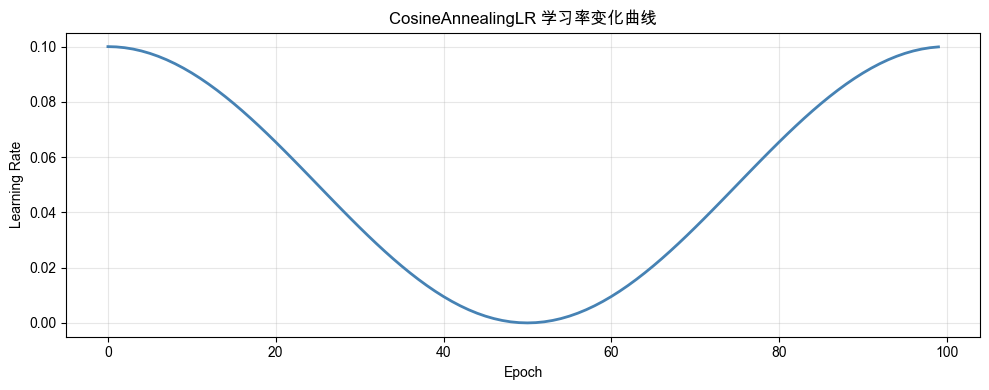

In [6]:
print("="*60)
print("  1.2 学习率调度器")
print("="*60)

# ============================================================
# 学习率调度器（第9章学过的内容）
# ============================================================

print("""
学习率调度器（Learning Rate Scheduler）:

在训练过程中动态调整学习率，通常:
- 开始时使用较大学习率（快速下降）
- 后期使用较小学习率（精细调整）
""")

# 创建模型和优化器
model = SimpleModel()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 常用调度器
print("常用学习率调度器:")
print("-"*40)

# 1. StepLR: 每step_size个epoch，lr乘以gamma
scheduler1 = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
print("StepLR: 每10个epoch，lr减半")

# 2. ExponentialLR: 每个epoch，lr乘以gamma
scheduler2 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print("ExponentialLR: 每epoch，lr *= 0.95")

# 3. CosineAnnealingLR: 余弦退火
scheduler3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
print("CosineAnnealingLR: 余弦曲线调整（推荐）")

# 4. ReduceLROnPlateau: 根据验证指标自动调整
scheduler4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
print("ReduceLROnPlateau: 验证损失不下降时自动降低lr")

# 可视化CosineAnnealingLR
print("\n可视化CosineAnnealingLR:")
lrs = []
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

for epoch in range(100):
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.figure(figsize=(10, 4))
plt.plot(lrs, linewidth=2, color='steelblue')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('CosineAnnealingLR 学习率变化曲线')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# Part 2：数据加载（DataLoader）

---

## 2.1 为什么需要DataLoader？

### 手动处理数据的痛点

```python
# NumPy方式：手动分批
batch_size = 32
n_batches = len(X_train) // batch_size

for epoch in range(epochs):
    # 手动打乱数据
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    for i in range(n_batches):
        # 手动切片
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]
        # 训练...
```

### PyTorch DataLoader：自动处理！

In [7]:
print("="*60)
print("  2.1 DataLoader基础用法")
print("="*60)

from torch.utils.data import DataLoader, TensorDataset

# ============================================================
# 步骤1: 准备数据（NumPy -> Tensor）
# ============================================================

# 模拟一些数据
X_numpy = np.random.randn(1000, 10).astype(np.float32)  # 1000个样本，10维特征
y_numpy = np.random.randint(0, 3, 1000)  # 3分类任务

# 转换为Tensor
X_tensor = torch.from_numpy(X_numpy)
y_tensor = torch.from_numpy(y_numpy).long()

print(f"数据形状: X={X_tensor.shape}, y={y_tensor.shape}")

# ============================================================
# 步骤2: 创建TensorDataset
# ============================================================

# TensorDataset: 将特征和标签打包在一起
dataset = TensorDataset(X_tensor, y_tensor)

print(f"\n数据集大小: {len(dataset)}")
print(f"单个样本: X形状={dataset[0][0].shape}, y={dataset[0][1]}")

# ============================================================
# 步骤3: 创建DataLoader
# ============================================================

# DataLoader: 自动批量化、打乱、多进程加载
dataloader = DataLoader(
    dataset,
    batch_size=32,    # 每批32个样本
    shuffle=True,     # 每个epoch打乱顺序
    # num_workers=2,  # 多进程加载（大数据集用）
)

print(f"\nDataLoader信息:")
print(f"  batch_size: 32")
print(f"  总batch数: {len(dataloader)}")
print(f"  总样本数: {len(dataloader.dataset)}")

  2.1 DataLoader基础用法
数据形状: X=torch.Size([1000, 10]), y=torch.Size([1000])

数据集大小: 1000
单个样本: X形状=torch.Size([10]), y=0

DataLoader信息:
  batch_size: 32
  总batch数: 32
  总样本数: 1000


In [8]:
print("="*60)
print("  2.1 遍历DataLoader")
print("="*60)

# ============================================================
# 遍历DataLoader（这就是训练循环中用的方式）
# ============================================================

print("\n遍历DataLoader:")
print("-"*40)

for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
    if batch_idx < 3:  # 只打印前3个batch
        print(f"Batch {batch_idx}: X形状={batch_X.shape}, y形状={batch_y.shape}")
    elif batch_idx == 3:
        print("...")

print(f"\n总共 {len(dataloader)} 个batch")

# ============================================================
# 对比：手写分批 vs DataLoader
# ============================================================

print("\n" + "="*60)
print("代码对比:")
print("="*60)
print("""
【NumPy手动分批】                     【PyTorch DataLoader】
─────────────────────────────────────────────────────────────
batch_size = 32                       dataloader = DataLoader(
n_batches = len(X) // batch_size          dataset,
                                          batch_size=32,
for epoch in range(epochs):               shuffle=True
    idx = np.random.permutation(n)    )
    X_shuf = X[idx]                   
    y_shuf = y[idx]                   for epoch in range(epochs):
                                          for X_batch, y_batch in dataloader:
    for i in range(n_batches):                # 训练...
        start = i * batch_size                pass
        end = start + batch_size
        X_batch = X_shuf[start:end]
        y_batch = y_shuf[start:end]
        # 训练...
─────────────────────────────────────────────────────────────
代码行数: ~12行                        代码行数: ~6行
功能: 基础分批                         功能: 分批+打乱+多进程+...                       
""")

  2.1 遍历DataLoader

遍历DataLoader:
----------------------------------------
Batch 0: X形状=torch.Size([32, 10]), y形状=torch.Size([32])
Batch 1: X形状=torch.Size([32, 10]), y形状=torch.Size([32])
Batch 2: X形状=torch.Size([32, 10]), y形状=torch.Size([32])
...

总共 32 个batch

代码对比:

【NumPy手动分批】                     【PyTorch DataLoader】
─────────────────────────────────────────────────────────────
batch_size = 32                       dataloader = DataLoader(
n_batches = len(X) // batch_size          dataset,
                                          batch_size=32,
for epoch in range(epochs):               shuffle=True
    idx = np.random.permutation(n)    )
    X_shuf = X[idx]                   
    y_shuf = y[idx]                   for epoch in range(epochs):
                                          for X_batch, y_batch in dataloader:
    for i in range(n_batches):                # 训练...
        start = i * batch_size                pass
        end = start + batch_size
        X_batch = X_shuf[star

---

# Part 3：完整训练循环

---

## 3.1 训练循环的标准结构

```python
# 标准PyTorch训练循环
for epoch in range(num_epochs):
    model.train()  # 训练模式
    for batch_X, batch_y in train_loader:
        # 1. 转移到设备
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # 2. 清零梯度
        optimizer.zero_grad()
        
        # 3. 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # 4. 反向传播
        loss.backward()
        
        # 5. 更新参数
        optimizer.step()
    
    # 验证
    model.eval()  # 评估模式
    with torch.no_grad():
        # 计算验证指标...
```

In [ ]:
print("="*60)
print("  3.1 对比：NumPy训练循环 vs PyTorch训练循环")
print("="*60)

print("""
╔══════════════════════════════════════════════════════════════════════════╗
║                    NumPy训练循环 vs PyTorch训练循环                       ║
╠══════════════════════════════════════════════════════════════════════════╣
║                                                                           ║
║  【NumPy手写训练循环】                                                    ║
║  ────────────────────────────────────────────────────────────────────── ║
║  for epoch in range(epochs):                                             ║
║      # 手动打乱数据                                                       ║
║      indices = np.random.permutation(n_samples)                          ║
║      X_shuffled = X_train[indices]                                       ║
║      y_shuffled = y_train[indices]                                       ║
║                                                                           ║
║      for i in range(n_batches):                                          ║
║          # 手动切片                                                       ║
║          X_batch = X_shuffled[i*bs:(i+1)*bs]                             ║
║          y_batch = y_shuffled[i*bs:(i+1)*bs]                             ║
║                                                                           ║
║          # 前向传播                                                       ║
║          y_pred = model.forward(X_batch)                                 ║
║                                                                           ║
║          # 手动反向传播（30+行代码）                                       ║
║          model.backward(X_batch, y_batch, y_pred)                        ║
║                                                                           ║
║          # 手动更新参数                                                   ║
║          optimizer.update(model)                                          ║
║                                                                           ║
╠══════════════════════════════════════════════════════════════════════════╣
║                                                                           ║
║  【PyTorch训练循环】                                                      ║
║  ────────────────────────────────────────────────────────────────────── ║
║  for epoch in range(epochs):                                             ║
║      model.train()                    # 训练模式                          ║
║      for X_batch, y_batch in train_loader:  # 自动分批和打乱              ║
║          X_batch = X_batch.to(device)  # GPU转移                          ║
║          y_batch = y_batch.to(device)                                    ║
║                                                                           ║
║          optimizer.zero_grad()         # 清零梯度                         ║
║          outputs = model(X_batch)      # 前向传播                         ║
║          loss = criterion(outputs, y_batch)                              ║
║          loss.backward()               # 自动反向传播！                   ║
║          optimizer.step()              # 自动更新参数！                   ║
║                                                                           ║
╚══════════════════════════════════════════════════════════════════════════╝
""")

---

# Part 4：实战项目

---

## 4.1 项目1：鸢尾花分类（Iris Classification）

### 任务描述
- **数据集**：sklearn.datasets.load_iris
- **特征**：4维（花萼长宽、花瓣长宽）
- **类别**：3类（Setosa, Versicolor, Virginica）
- **样本数**：150

In [9]:
print("="*60)
print("  4.1 鸢尾花分类 - 数据准备")
print("="*60)

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================================
# 1. 加载数据
# ============================================================
iris = load_iris()
X, y = iris.data, iris.target

print(f"数据集信息:")
print(f"  特征形状: {X.shape}")
print(f"  标签形状: {y.shape}")
print(f"  类别: {iris.target_names}")
print(f"  特征名: {iris.feature_names}")

# ============================================================
# 2. 数据预处理
# ============================================================

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 标准化（神经网络必须！）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\n划分后:")
print(f"  训练集: {X_train.shape}")
print(f"  测试集: {X_test.shape}")

# ============================================================
# 3. 转换为PyTorch格式
# ============================================================

# NumPy -> Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

print(f"\nDataLoader:")
print(f"  batch_size: 16")
print(f"  总batch数: {len(train_loader)}")

  4.1 鸢尾花分类 - 数据准备
数据集信息:
  特征形状: (150, 4)
  标签形状: (150,)
  类别: ['setosa' 'versicolor' 'virginica']
  特征名: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

划分后:
  训练集: (120, 4)
  测试集: (30, 4)

DataLoader:
  batch_size: 16
  总batch数: 8


In [10]:
print("="*60)
print("  4.1 鸢尾花分类 - 定义模型")
print("="*60)

# ============================================================
# 定义MLP模型
# ============================================================

class IrisClassifier(nn.Module):
    """
    鸢尾花分类器
    
    结构: 4 -> 16 -> 8 -> 3
    
    参数:
        input_size: 输入特征数（4）
        num_classes: 类别数（3）
    """
    
    def __init__(self, input_size=4, num_classes=3):
        super().__init__()
        
        # 网络层
        # 输入层 -> 第一隐藏层
        self.fc1 = nn.Linear(input_size, 16)
        
        # 第一隐藏层 -> 第二隐藏层
        self.fc2 = nn.Linear(16, 8)
        
        # 第二隐藏层 -> 输出层
        self.fc3 = nn.Linear(8, num_classes)
    
    def forward(self, x):
        """
        前向传播
        
        x: (batch_size, 4) -> (batch_size, 3)
        """
        # 第一层 + ReLU
        x = F.relu(self.fc1(x))
        
        # 第二层 + ReLU
        x = F.relu(self.fc2(x))
        
        # 输出层（不加激活，CrossEntropyLoss会处理）
        x = self.fc3(x)
        
        return x


# 创建模型
model = IrisClassifier(input_size=4, num_classes=3)
model = model.to(device)  # 转移到GPU/MPS

print(f"模型结构:")
print(model)

# 参数统计
total_params = sum(p.numel() for p in model.parameters())
print(f"\n总参数数: {total_params}")
print(f"  = 4×16+16 + 16×8+8 + 8×3+3")
print(f"  = {4*16+16} + {16*8+8} + {8*3+3}")

  4.1 鸢尾花分类 - 定义模型
模型结构:
IrisClassifier(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)

总参数数: 243
  = 4×16+16 + 16×8+8 + 8×3+3
  = 80 + 136 + 27


In [11]:
print("="*60)
print("  4.1 鸢尾花分类 - 训练模型")
print("="*60)

# ============================================================
# 设置训练组件
# ============================================================

# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练参数
num_epochs = 100

# 记录训练过程
train_losses = []
test_accuracies = []

print(f"训练配置:")
print(f"  损失函数: CrossEntropyLoss")
print(f"  优化器: Adam (lr=0.01)")
print(f"  训练轮数: {num_epochs}")
print(f"  设备: {device}")

# ============================================================
# 训练循环
# ============================================================

print(f"\n开始训练...")
print("-"*50)

for epoch in range(num_epochs):
    # ===== 训练阶段 =====
    model.train()  # 设置为训练模式
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # 转移到设备
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # 标准训练三步骤
        optimizer.zero_grad()           # 1. 清零梯度
        outputs = model(batch_X)        # 2. 前向传播
        loss = criterion(outputs, batch_y)
        loss.backward()                 # 3. 反向传播
        optimizer.step()                # 4. 更新参数
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # ===== 验证阶段 =====
    model.eval()  # 设置为评估模式
    with torch.no_grad():  # 不计算梯度（节省内存）
        # 将测试数据转移到设备
        X_test_dev = X_test_tensor.to(device)
        y_test_dev = y_test_tensor.to(device)
        
        # 预测
        test_outputs = model(X_test_dev)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_dev).float().mean().item()
        test_accuracies.append(accuracy)
    
    # 打印进度
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}]  "
              f"Loss: {avg_loss:.4f}  "
              f"Test Acc: {accuracy:.4f}")

print("-"*50)
print(f"训练完成！最终测试准确率: {test_accuracies[-1]:.4f}")

  4.1 鸢尾花分类 - 训练模型
训练配置:
  损失函数: CrossEntropyLoss
  优化器: Adam (lr=0.01)
  训练轮数: 100
  设备: mps

开始训练...
--------------------------------------------------
Epoch [ 20/100]  Loss: 0.0584  Test Acc: 0.9667
Epoch [ 40/100]  Loss: 0.0383  Test Acc: 0.9667
Epoch [ 60/100]  Loss: 0.0309  Test Acc: 0.9333
Epoch [ 80/100]  Loss: 0.0220  Test Acc: 0.9667
Epoch [100/100]  Loss: 0.0169  Test Acc: 0.9333
--------------------------------------------------
训练完成！最终测试准确率: 0.9333


  4.1 鸢尾花分类 - 可视化结果


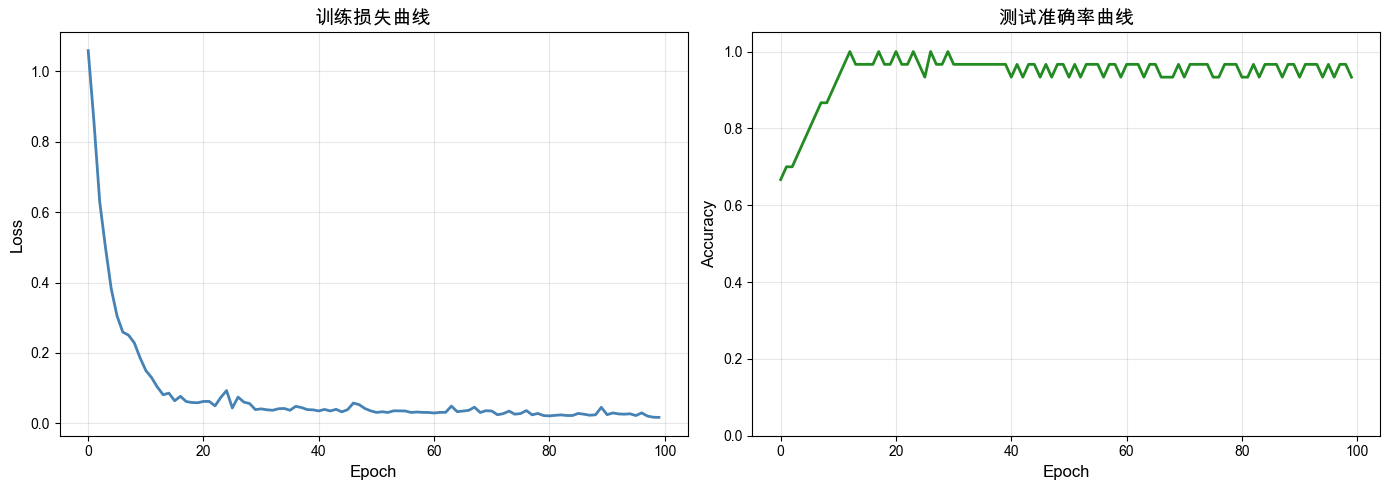


详细评估:
----------------------------------------

分类报告:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


混淆矩阵:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


In [12]:
print("="*60)
print("  4.1 鸢尾花分类 - 可视化结果")
print("="*60)

# ============================================================
# 可视化训练过程
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 训练损失
axes[0].plot(train_losses, linewidth=2, color='steelblue')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('训练损失曲线', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 测试准确率
axes[1].plot(test_accuracies, linewidth=2, color='forestgreen')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('测试准确率曲线', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 详细评估
# ============================================================

print("\n详细评估:")
print("-"*40)

model.eval()
with torch.no_grad():
    X_test_dev = X_test_tensor.to(device)
    outputs = model(X_test_dev)
    probs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)
    
    # 转回CPU
    predicted = predicted.cpu().numpy()
    probs = probs.cpu().numpy()

# 混淆矩阵
from sklearn.metrics import confusion_matrix, classification_report

print("\n分类报告:")
print(classification_report(y_test, predicted, target_names=iris.target_names))

print("\n混淆矩阵:")
cm = confusion_matrix(y_test, predicted)
print(cm)

---

## 4.2 项目2：手写数字识别（MNIST-like）

### 任务描述
- **数据集**：sklearn.datasets.load_digits（8x8图像，类似MNIST）
- **特征**：64维（8x8=64像素）
- **类别**：10类（数字0-9）
- **样本数**：1797

  4.2 手写数字识别 - 数据准备
数据集信息:
  样本数: 1797
  特征数: 64 (8×8像素)
  类别数: 10 (数字0-9)


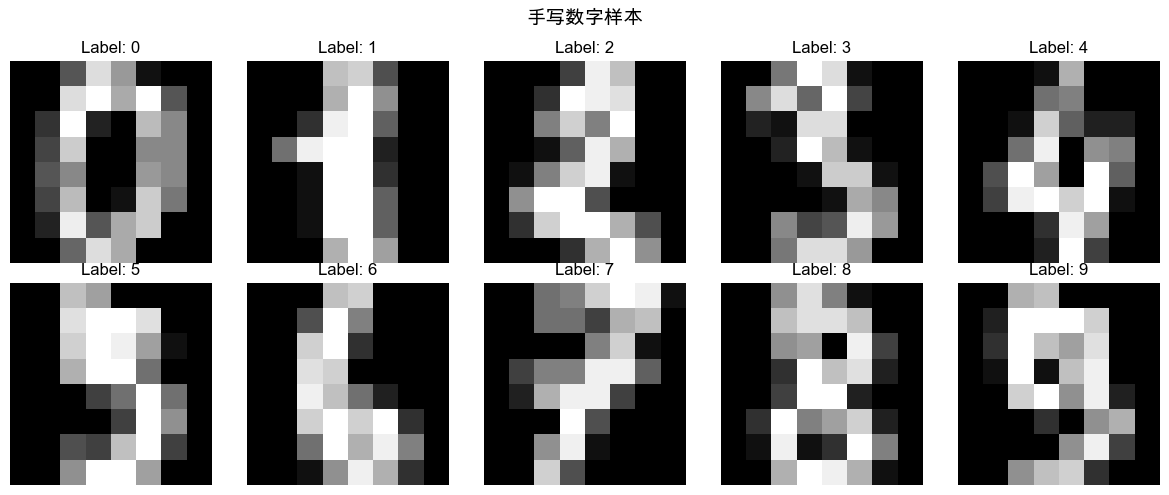


数据划分:
  训练集: 1437 样本
  测试集: 360 样本


In [13]:
print("="*60)
print("  4.2 手写数字识别 - 数据准备")
print("="*60)

from sklearn.datasets import load_digits

# ============================================================
# 1. 加载数据
# ============================================================

digits = load_digits()
X, y = digits.data, digits.target

print(f"数据集信息:")
print(f"  样本数: {X.shape[0]}")
print(f"  特征数: {X.shape[1]} (8×8像素)")
print(f"  类别数: {len(np.unique(y))} (数字0-9)")

# ============================================================
# 2. 可视化部分样本
# ============================================================

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {digits.target[i]}', fontsize=12)
    ax.axis('off')
plt.suptitle('手写数字样本', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# 3. 数据预处理
# ============================================================

# 划分数据
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 转换为Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"\n数据划分:")
print(f"  训练集: {len(X_train)} 样本")
print(f"  测试集: {len(X_test)} 样本")

In [14]:
print("="*60)
print("  4.2 手写数字识别 - 定义更深的模型")
print("="*60)

# ============================================================
# 定义更复杂的MLP（带BN和Dropout）
# ============================================================

class DigitClassifier(nn.Module):
    """
    手写数字分类器
    
    结构: 64 -> 256 -> 128 -> 64 -> 10
    
    特点:
    - Batch Normalization: 加速训练，稳定收敛
    - Dropout: 防止过拟合
    """
    
    def __init__(self, input_size=64, num_classes=10, dropout_rate=0.3):
        super().__init__()
        
        # 第一层: 64 -> 256
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        # 第二层: 256 -> 128
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        # 第三层: 128 -> 64
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        # 输出层: 64 -> 10
        self.fc4 = nn.Linear(64, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        # 第一层: Linear -> BN -> ReLU -> Dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第二层
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第三层
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 输出层
        x = self.fc4(x)
        
        return x


# 创建模型
model = DigitClassifier(input_size=64, num_classes=10)
model = model.to(device)

print(f"模型结构:")
print(model)

# 参数统计
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n总参数数: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")

  4.2 手写数字识别 - 定义更深的模型
模型结构:
DigitClassifier(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

总参数数: 59,338
可训练参数: 59,338


In [15]:
print("="*60)
print("  4.2 手写数字识别 - 训练模型")
print("="*60)

# ============================================================
# 训练配置
# ============================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

num_epochs = 50

train_losses = []
test_accuracies = []
learning_rates = []

print(f"训练配置:")
print(f"  损失函数: CrossEntropyLoss")
print(f"  优化器: Adam (lr=0.001)")
print(f"  调度器: CosineAnnealingLR")
print(f"  训练轮数: {num_epochs}")

# ============================================================
# 训练循环
# ============================================================

print(f"\n开始训练...")
print("-"*50)

for epoch in range(num_epochs):
    # ===== 训练阶段 =====
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # 记录学习率
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # 更新学习率
    scheduler.step()
    
    # ===== 验证阶段 =====
    model.eval()
    with torch.no_grad():
        X_test_dev = X_test_tensor.to(device)
        y_test_dev = y_test_tensor.to(device)
        
        test_outputs = model(X_test_dev)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_dev).float().mean().item()
        test_accuracies.append(accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}]  "
              f"Loss: {avg_loss:.4f}  "
              f"Test Acc: {accuracy:.4f}  "
              f"LR: {current_lr:.6f}")

print("-"*50)
print(f"训练完成！最终测试准确率: {test_accuracies[-1]:.4f}")

  4.2 手写数字识别 - 训练模型
训练配置:
  损失函数: CrossEntropyLoss
  优化器: Adam (lr=0.001)
  调度器: CosineAnnealingLR
  训练轮数: 50

开始训练...
--------------------------------------------------
Epoch [ 10/50]  Loss: 0.1616  Test Acc: 0.9861  LR: 0.000922
Epoch [ 20/50]  Loss: 0.0636  Test Acc: 0.9861  LR: 0.000684
Epoch [ 30/50]  Loss: 0.0336  Test Acc: 0.9861  LR: 0.000376
Epoch [ 40/50]  Loss: 0.0342  Test Acc: 0.9889  LR: 0.000115
Epoch [ 50/50]  Loss: 0.0280  Test Acc: 0.9889  LR: 0.000001
--------------------------------------------------
训练完成！最终测试准确率: 0.9889


  4.2 手写数字识别 - 可视化结果


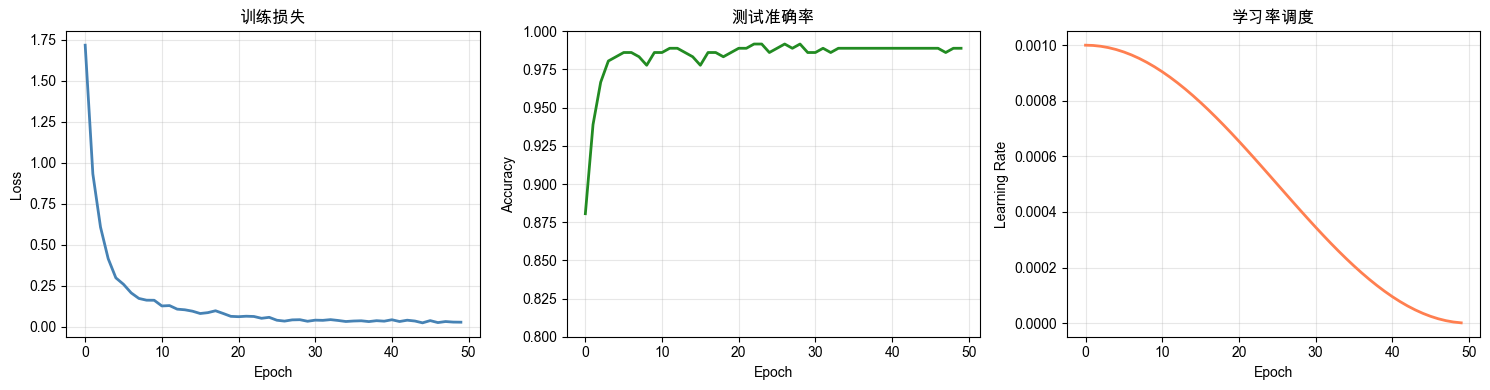


预测错误的样本数: 4/360


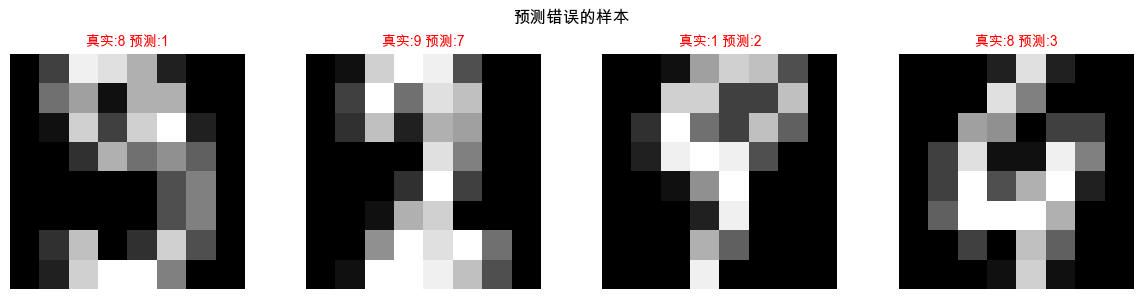

In [16]:
print("="*60)
print("  4.2 手写数字识别 - 可视化结果")
print("="*60)

# ============================================================
# 可视化训练过程
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 训练损失
axes[0].plot(train_losses, linewidth=2, color='steelblue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('训练损失', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 测试准确率
axes[1].plot(test_accuracies, linewidth=2, color='forestgreen')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('测试准确率', fontweight='bold')
axes[1].set_ylim(0.8, 1.0)
axes[1].grid(True, alpha=0.3)

# 学习率变化
axes[2].plot(learning_rates, linewidth=2, color='coral')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('学习率调度', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 可视化预测结果
# ============================================================

model.eval()
with torch.no_grad():
    X_test_dev = X_test_tensor.to(device)
    outputs = model(X_test_dev)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

# 找出预测错误的样本
errors = np.where(predicted != y_test)[0]
print(f"\n预测错误的样本数: {len(errors)}/{len(y_test)}")

if len(errors) > 0:
    # 可视化部分错误预测
    fig, axes = plt.subplots(1, min(5, len(errors)), figsize=(12, 3))
    if len(errors) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i >= len(errors):
            break
        idx = errors[i]
        # 从原始数据中获取图像
        img = digits.images[len(X_train) + idx]  # 注意偏移
        ax.imshow(img, cmap='gray')
        ax.set_title(f'真实:{y_test[idx]} 预测:{predicted[idx]}', fontsize=10, color='red')
        ax.axis('off')
    
    plt.suptitle('预测错误的样本', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("所有样本预测正确！")

---

## 4.3 项目3：糖尿病进展预测（Diabetes Progression - 回归任务）

### 任务描述
- **数据集**：sklearn.datasets.load_diabetes
- **特征**：10维（年龄、性别、BMI、血压、6项血清指标）
- **目标**：预测一年后的病情进展指标（连续值）
- **样本数**：442

### 🔑 分类 vs 回归的关键差异

| 对比项 | 分类任务 | 回归任务 |
|--------|----------|----------|
| **输出层** | `nn.Linear(hidden, num_classes)` | `nn.Linear(hidden, 1)` |
| **激活函数** | 无（CrossEntropy内含softmax） | 无（直接输出数值） |
| **损失函数** | `nn.CrossEntropyLoss()` | `nn.MSELoss()` 或 `nn.L1Loss()` |
| **评估指标** | 准确率 (Accuracy) | MSE / MAE / R² |
| **标签格式** | 整数类别 `[0, 1, 2]` | 浮点数 `[151.0, 75.0, ...]` |

  4.3 糖尿病进展预测 - 数据准备
数据集信息:
  样本数: 442
  特征数: 10

特征名称:
  1. age
  2. sex
  3. bmi
  4. bp
  5. s1
  6. s2
  7. s3
  8. s4
  9. s5
  10. s6

目标变量（病情进展指标）:
  最小值: 25.0
  最大值: 346.0
  平均值: 152.1
  标准差: 77.0


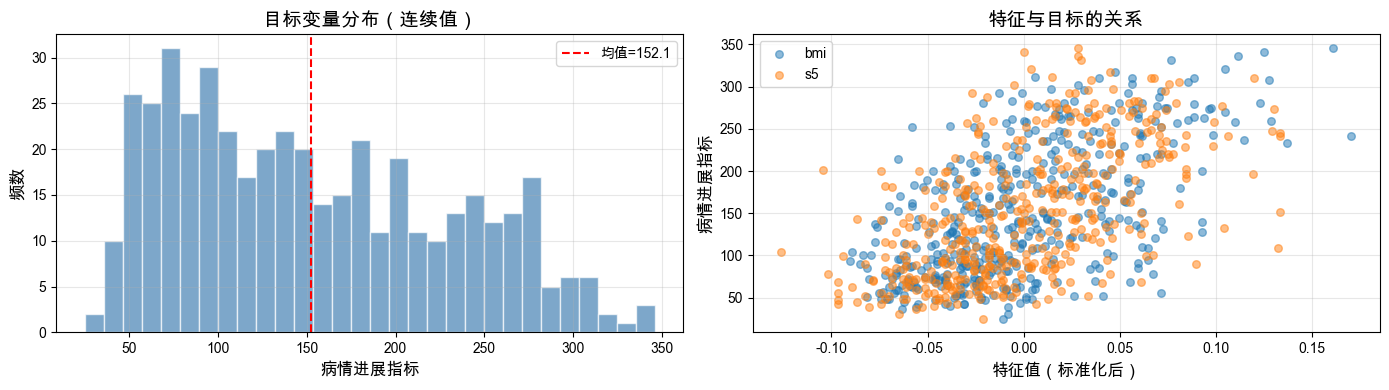


数据划分:
  训练集: 353 样本
  测试集: 89 样本

Tensor类型对比:
  分类任务标签: torch.LongTensor (整数)
  回归任务标签: torch.FloatTensor (浮点数) ✓

  y_train_tensor.dtype = torch.float32


In [19]:
print("="*60)
print("  4.3 糖尿病进展预测 - 数据准备")
print("="*60)

from sklearn.datasets import load_diabetes

# ============================================================
# 1. 加载数据
# ============================================================

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

print(f"数据集信息:")
print(f"  样本数: {X.shape[0]}")
print(f"  特征数: {X.shape[1]}")
print(f"\n特征名称:")
for i, name in enumerate(diabetes.feature_names):
    print(f"  {i+1}. {name}")

print(f"\n目标变量（病情进展指标）:")
print(f"  最小值: {y.min():.1f}")
print(f"  最大值: {y.max():.1f}")
print(f"  平均值: {y.mean():.1f}")
print(f"  标准差: {y.std():.1f}")

# ============================================================
# 2. 可视化目标变量分布
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 目标变量分布
axes[0].hist(y, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].set_xlabel('病情进展指标', fontsize=12)
axes[0].set_ylabel('频数', fontsize=12)
axes[0].set_title('目标变量分布（连续值）', fontsize=14, fontweight='bold')
axes[0].axvline(y.mean(), color='red', linestyle='--', label=f'均值={y.mean():.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 特征相关性（选择几个重要特征）
important_features = ['bmi', 's5']  # BMI和血清指标s5
for feat_name in important_features:
    feat_idx = list(diabetes.feature_names).index(feat_name)
    axes[1].scatter(X[:, feat_idx], y, alpha=0.5, label=feat_name, s=30)
axes[1].set_xlabel('特征值（标准化后）', fontsize=12)
axes[1].set_ylabel('病情进展指标', fontsize=12)
axes[1].set_title('特征与目标的关系', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 3. 数据预处理
# ============================================================

# 划分数据
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化特征（sklearn的diabetes数据已经标准化，但我们再做一次确保）
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# ⚠️ 回归任务：标签也需要标准化（加速收敛，稳定训练）
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"\n数据划分:")
print(f"  训练集: {len(X_train)} 样本")
print(f"  测试集: {len(X_test)} 样本")

# ============================================================
# 4. 转换为PyTorch格式
# ============================================================

# NumPy -> Tensor
# ⚠️ 回归任务：标签用 FloatTensor，不是 LongTensor！
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)  # 浮点数！
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"\nTensor类型对比:")
print(f"  分类任务标签: torch.LongTensor (整数)")
print(f"  回归任务标签: torch.FloatTensor (浮点数) ✓")
print(f"\n  y_train_tensor.dtype = {y_train_tensor.dtype}")

In [20]:
print("="*60)
print("  4.3 糖尿病进展预测 - 定义回归模型")
print("="*60)

# ============================================================
# 定义回归模型
# ============================================================

class DiabetesRegressor(nn.Module):
    """
    糖尿病进展预测模型（回归任务）
    
    结构: 10 -> 64 -> 32 -> 16 -> 1
    
    与分类模型的关键差异:
    1. 输出层只有1个神经元（预测一个连续值）
    2. 输出层不加激活函数（允许输出任意实数）
    3. 使用MSELoss而不是CrossEntropyLoss
    """
    
    def __init__(self, input_size=10):
        super().__init__()
        
        # ============================================================
        # 网络结构: 10 -> 64 -> 32 -> 16 -> 1
        # ============================================================
        
        # 第一层: 10 -> 64 (扩展维度)
        self.fc1 = nn.Linear(input_size, 64)
        
        # 第二层: 64 -> 32
        self.fc2 = nn.Linear(64, 32)
        
        # 第三层: 32 -> 16
        self.fc3 = nn.Linear(32, 16)
        
        # 输出层: 16 -> 1 （⚠️ 只有1个神经元！）
        self.fc4 = nn.Linear(16, 1)
        
        # Dropout（回归任务也可以用，防止过拟合）
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        """
        前向传播
        
        x: (batch_size, 10) -> (batch_size, 1)
        
        注意: 输出层不加激活函数！
        - 分类: 不加是因为CrossEntropyLoss内含softmax
        - 回归: 不加是因为要输出任意实数范围
        """
        # 第一层: Linear -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # 第二层
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # 第三层
        x = F.relu(self.fc3(x))
        
        # 输出层（⚠️ 无激活函数！直接输出预测值）
        x = self.fc4(x)
        
        return x


# 创建模型
reg_model = DiabetesRegressor(input_size=10)
reg_model = reg_model.to(device)

print("模型结构:")
print(reg_model)

# 参数统计
total_params = sum(p.numel() for p in reg_model.parameters())
print(f"\n总参数数: {total_params:,}")

# ============================================================
# 对比分类模型 vs 回归模型
# ============================================================

print("\n" + "="*60)
print("分类模型 vs 回归模型 对比:")
print("="*60)
print("""
┌─────────────────┬──────────────────────┬──────────────────────┐
│     对比项      │      分类模型         │      回归模型         │
├─────────────────┼──────────────────────┼──────────────────────┤
│ 输出层          │ nn.Linear(h, n_cls)  │ nn.Linear(h, 1)      │
│ 输出形状        │ (batch, num_classes) │ (batch, 1)           │
│ 输出激活        │ 无(CE内含softmax)    │ 无(直接输出)         │
│ 标签类型        │ LongTensor (整数)    │ FloatTensor (浮点)   │
│ 损失函数        │ CrossEntropyLoss     │ MSELoss / L1Loss     │
└─────────────────┴──────────────────────┴──────────────────────┘
""")

  4.3 糖尿病进展预测 - 定义回归模型
模型结构:
DiabetesRegressor(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

总参数数: 3,329

分类模型 vs 回归模型 对比:

┌─────────────────┬──────────────────────┬──────────────────────┐
│     对比项      │      分类模型         │      回归模型         │
├─────────────────┼──────────────────────┼──────────────────────┤
│ 输出层          │ nn.Linear(h, n_cls)  │ nn.Linear(h, 1)      │
│ 输出形状        │ (batch, num_classes) │ (batch, 1)           │
│ 输出激活        │ 无(CE内含softmax)    │ 无(直接输出)         │
│ 标签类型        │ LongTensor (整数)    │ FloatTensor (浮点)   │
│ 损失函数        │ CrossEntropyLoss     │ MSELoss / L1Loss     │
└─────────────────┴──────────────────────┴──────────────────────┘



In [21]:
print("="*60)
print("  4.3 糖尿病进展预测 - 训练模型")
print("="*60)

# ============================================================
# 训练配置
# ============================================================

# ⚠️ 回归任务使用MSELoss，不是CrossEntropyLoss！
criterion = nn.MSELoss()

# 优化器
optimizer = optim.Adam(reg_model.parameters(), lr=0.01)

# 学习率调度
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # 监控的指标越小越好
    patience=10,     # 10轮不下降就降低lr
    factor=0.5       # lr减半
)

num_epochs = 200

# 记录训练过程
train_losses = []
test_losses = []
test_r2_scores = []

print(f"训练配置:")
print(f"  损失函数: MSELoss (均方误差) ← 回归任务标配")
print(f"  优化器: Adam (lr=0.01)")
print(f"  调度器: ReduceLROnPlateau")
print(f"  训练轮数: {num_epochs}")

# ============================================================
# 训练循环
# ============================================================

print(f"\n开始训练...")
print("-"*60)

for epoch in range(num_epochs):
    # ===== 训练阶段 =====
    reg_model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        # ⚠️ 回归任务：标签需要reshape成(batch, 1)与模型输出匹配
        batch_y = batch_y.to(device).unsqueeze(1)  # (batch,) -> (batch, 1)
        
        optimizer.zero_grad()
        
        # 前向传播
        predictions = reg_model(batch_X)  # 输出形状: (batch, 1)
        
        # 计算MSE损失
        loss = criterion(predictions, batch_y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ===== 验证阶段 =====
    reg_model.eval()
    with torch.no_grad():
        X_test_dev = X_test_tensor.to(device)
        y_test_dev = y_test_tensor.to(device).unsqueeze(1)
        
        test_predictions = reg_model(X_test_dev)
        test_loss = criterion(test_predictions, y_test_dev).item()
        test_losses.append(test_loss)
        
        # 计算R²分数（需要转回原始尺度）
        # R² = 1 - SS_res / SS_tot
        y_pred_np = test_predictions.cpu().numpy().flatten()
        y_true_np = y_test_tensor.numpy()
        
        # 反标准化
        y_pred_original = scaler_y.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_true_original = y_test  # 原始测试标签
        
        ss_res = np.sum((y_true_original - y_pred_original) ** 2)
        ss_tot = np.sum((y_true_original - y_true_original.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot
        test_r2_scores.append(r2)
    
    # 更新学习率
    scheduler.step(test_loss)
    
    # 打印进度
    if (epoch + 1) % 40 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:3d}/{num_epochs}]  "
              f"Train Loss: {avg_train_loss:.4f}  "
              f"Test Loss: {test_loss:.4f}  "
              f"R²: {r2:.4f}  "
              f"LR: {current_lr:.6f}")

print("-"*60)
print(f"训练完成！")
print(f"  最终测试MSE: {test_losses[-1]:.4f}")
print(f"  最终R²分数: {test_r2_scores[-1]:.4f}")

# ============================================================
# 评估指标说明
# ============================================================

print("\n" + "="*60)
print("回归任务评估指标说明:")
print("="*60)
print("""
┌─────────────┬─────────────────────────────────────────────────┐
│   指标      │   说明                                          │
├─────────────┼─────────────────────────────────────────────────┤
│ MSE         │ 均方误差 = mean((y_pred - y_true)²)            │
│             │ 越小越好，对大误差敏感                          │
├─────────────┼─────────────────────────────────────────────────┤
│ MAE         │ 平均绝对误差 = mean(|y_pred - y_true|)         │
│             │ 越小越好，对异常值更鲁棒                        │
├─────────────┼─────────────────────────────────────────────────┤
│ R²          │ 决定系数 = 1 - SS_res/SS_tot                   │
│             │ 范围[-∞, 1]，1表示完美预测，0表示和均值一样    │
└─────────────┴─────────────────────────────────────────────────┘
""")

  4.3 糖尿病进展预测 - 训练模型
训练配置:
  损失函数: MSELoss (均方误差) ← 回归任务标配
  优化器: Adam (lr=0.01)
  调度器: ReduceLROnPlateau
  训练轮数: 200

开始训练...
------------------------------------------------------------
Epoch [ 40/200]  Train Loss: 0.3697  Test Loss: 0.4311  R²: 0.5055  LR: 0.005000
Epoch [ 80/200]  Train Loss: 0.2884  Test Loss: 0.4275  R²: 0.5097  LR: 0.000313
Epoch [120/200]  Train Loss: 0.2980  Test Loss: 0.4319  R²: 0.5046  LR: 0.000020
Epoch [160/200]  Train Loss: 0.2899  Test Loss: 0.4323  R²: 0.5042  LR: 0.000002
Epoch [200/200]  Train Loss: 0.3543  Test Loss: 0.4323  R²: 0.5042  LR: 0.000000
------------------------------------------------------------
训练完成！
  最终测试MSE: 0.4323
  最终R²分数: 0.5042

回归任务评估指标说明:

┌─────────────┬─────────────────────────────────────────────────┐
│   指标      │   说明                                          │
├─────────────┼─────────────────────────────────────────────────┤
│ MSE         │ 均方误差 = mean((y_pred - y_true)²)            │
│             │ 越小越好，对大误差敏感         

  4.3 糖尿病进展预测 - 可视化结果


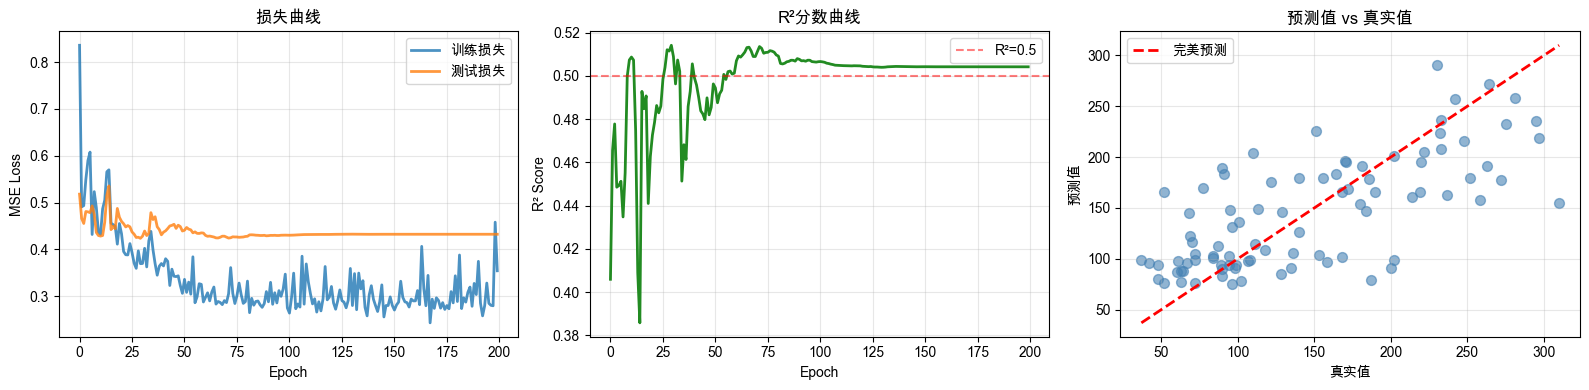


详细评估指标:
----------------------------------------
  MSE  (均方误差):       2626.91
  RMSE (均方根误差):     51.25
  MAE  (平均绝对误差):   39.61
  R²   (决定系数):       0.5042

解读:
  - 平均预测误差约 39.6 个单位
  - 模型解释了 50.4% 的目标变量方差


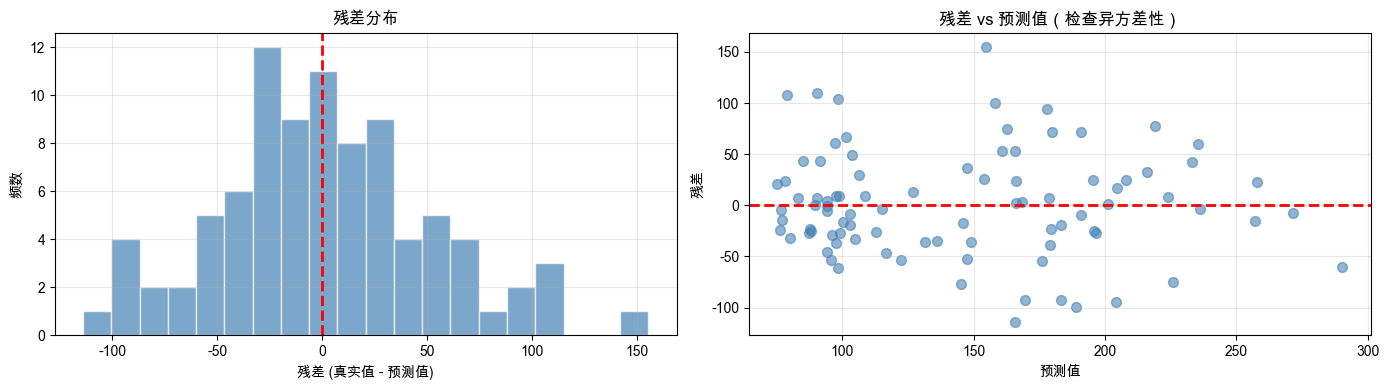


残差分析说明:
  - 残差应近似正态分布（左图）
  - 残差应随机分布在0附近，无明显模式（右图）
  - 如果右图呈现喇叭形，说明存在异方差性


In [22]:
print("="*60)
print("  4.3 糖尿病进展预测 - 可视化结果")
print("="*60)

# ============================================================
# 1. 训练过程可视化
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 训练/测试损失
axes[0].plot(train_losses, label='训练损失', linewidth=2, alpha=0.8)
axes[0].plot(test_losses, label='测试损失', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('损失曲线', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R²分数
axes[1].plot(test_r2_scores, linewidth=2, color='forestgreen')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R²分数曲线', fontweight='bold')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='R²=0.5')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 预测 vs 真实值散点图
reg_model.eval()
with torch.no_grad():
    X_test_dev = X_test_tensor.to(device)
    predictions = reg_model(X_test_dev).cpu().numpy().flatten()
    
    # 反标准化回原始尺度
    y_pred_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_true_original = y_test

axes[2].scatter(y_true_original, y_pred_original, alpha=0.6, s=50, c='steelblue')
# 完美预测线
min_val = min(y_true_original.min(), y_pred_original.min())
max_val = max(y_true_original.max(), y_pred_original.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='完美预测')
axes[2].set_xlabel('真实值')
axes[2].set_ylabel('预测值')
axes[2].set_title('预测值 vs 真实值', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 2. 详细评估指标
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n详细评估指标:")
print("-"*40)

mse = mean_squared_error(y_true_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_original, y_pred_original)
r2 = r2_score(y_true_original, y_pred_original)

print(f"  MSE  (均方误差):       {mse:.2f}")
print(f"  RMSE (均方根误差):     {rmse:.2f}")
print(f"  MAE  (平均绝对误差):   {mae:.2f}")
print(f"  R²   (决定系数):       {r2:.4f}")

print(f"\n解读:")
print(f"  - 平均预测误差约 {mae:.1f} 个单位")
print(f"  - 模型解释了 {r2*100:.1f}% 的目标变量方差")

# ============================================================
# 3. 残差分析
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

residuals = y_true_original - y_pred_original

# 残差分布
axes[0].hist(residuals, bins=20, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('残差 (真实值 - 预测值)')
axes[0].set_ylabel('频数')
axes[0].set_title('残差分布', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 残差 vs 预测值
axes[1].scatter(y_pred_original, residuals, alpha=0.6, s=50, c='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('预测值')
axes[1].set_ylabel('残差')
axes[1].set_title('残差 vs 预测值（检查异方差性）', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n残差分析说明:")
print("  - 残差应近似正态分布（左图）")
print("  - 残差应随机分布在0附近，无明显模式（右图）")
print("  - 如果右图呈现喇叭形，说明存在异方差性")

---

# Part 5：模型保存与加载

---

In [17]:
print("="*60)
print("  5.1 模型保存与加载")
print("="*60)

# ============================================================
# 方式1: 保存整个模型（简单但不推荐）
# ============================================================

print("\n方式1: 保存整个模型")
print("-"*40)

# 保存
torch.save(model, 'digit_classifier_full.pth')
print("已保存: digit_classifier_full.pth")

# 加载
loaded_model_full = torch.load('digit_classifier_full.pth', weights_only=False)
loaded_model_full.eval()
print("已加载模型")

# 测试
with torch.no_grad():
    test_output = loaded_model_full(X_test_tensor[:5].to(device))
    _, preds = torch.max(test_output, 1)
    print(f"测试预测: {preds.cpu().numpy()}")
    print(f"真实标签: {y_test[:5]}")

print("\n⚠️ 注意: 这种方式依赖于模型类的定义必须存在")

# ============================================================
# 方式2: 只保存参数（推荐）
# ============================================================

print("\n" + "="*60)
print("方式2: 只保存参数（推荐）")
print("-"*40)

# 保存
torch.save(model.state_dict(), 'digit_classifier_params.pth')
print("已保存: digit_classifier_params.pth")

# 加载
# 首先需要创建模型实例
new_model = DigitClassifier(input_size=64, num_classes=10)
new_model.load_state_dict(torch.load('digit_classifier_params.pth', weights_only=True))
new_model = new_model.to(device)
new_model.eval()
print("已加载参数到新模型")

# 测试
with torch.no_grad():
    test_output = new_model(X_test_tensor[:5].to(device))
    _, preds = torch.max(test_output, 1)
    print(f"测试预测: {preds.cpu().numpy()}")
    print(f"真实标签: {y_test[:5]}")

print("\n✅ 推荐使用这种方式，更灵活、更安全")

  5.1 模型保存与加载

方式1: 保存整个模型
----------------------------------------
已保存: digit_classifier_full.pth
已加载模型
测试预测: [5 2 8 1 7]
真实标签: [5 2 8 1 7]

⚠️ 注意: 这种方式依赖于模型类的定义必须存在

方式2: 只保存参数（推荐）
----------------------------------------
已保存: digit_classifier_params.pth
已加载参数到新模型
测试预测: [5 2 8 1 7]
真实标签: [5 2 8 1 7]

✅ 推荐使用这种方式，更灵活、更安全


In [18]:
print("="*60)
print("  5.2 保存完整训练状态（用于恢复训练）")
print("="*60)

# ============================================================
# 保存完整训练状态（用于中断后恢复训练）
# ============================================================

print("\n保存完整训练状态:")
print("-"*40)

checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'test_accuracies': test_accuracies,
    'best_accuracy': max(test_accuracies),
}

torch.save(checkpoint, 'digit_classifier_checkpoint.pth')
print("已保存: digit_classifier_checkpoint.pth")
print(f"  包含: epoch, model, optimizer, scheduler, 训练历史")

# ============================================================
# 恢复训练
# ============================================================

print("\n恢复训练:")
print("-"*40)

# 加载checkpoint
checkpoint = torch.load('digit_classifier_checkpoint.pth', weights_only=False)

# 创建模型和优化器
resume_model = DigitClassifier(input_size=64, num_classes=10)
resume_model.load_state_dict(checkpoint['model_state_dict'])
resume_model = resume_model.to(device)

resume_optimizer = optim.Adam(resume_model.parameters())
resume_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

resume_scheduler = optim.lr_scheduler.CosineAnnealingLR(resume_optimizer, T_max=50)
resume_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

start_epoch = checkpoint['epoch']
best_acc = checkpoint['best_accuracy']

print(f"  从第 {start_epoch} 轮恢复")
print(f"  最佳准确率: {best_acc:.4f}")
print(f"  当前学习率: {resume_optimizer.param_groups[0]['lr']:.6f}")

# 清理临时文件
import os
for f in ['digit_classifier_full.pth', 'digit_classifier_params.pth', 'digit_classifier_checkpoint.pth']:
    if os.path.exists(f):
        os.remove(f)
print("\n临时文件已清理")

  5.2 保存完整训练状态（用于恢复训练）

保存完整训练状态:
----------------------------------------
已保存: digit_classifier_checkpoint.pth
  包含: epoch, model, optimizer, scheduler, 训练历史

恢复训练:
----------------------------------------
  从第 50 轮恢复
  最佳准确率: 0.9917
  当前学习率: 0.000000

临时文件已清理


---

## 📝 本章小结

### 🎯 核心概念回顾

| 组件 | PyTorch | 对比手写实现 |
|------|---------|-------------|
| **损失函数** | `nn.CrossEntropyLoss()` / `nn.MSELoss()` | 需手写公式 |
| **优化器** | `optim.Adam(params, lr)` | 需手写50+行 |
| **数据加载** | `DataLoader(dataset, batch)` | 需手写分批 |
| **模型保存** | `torch.save(state_dict)` | 无标准方式 |

### 🔑 分类 vs 回归任务对比

| 对比项 | 分类任务 | 回归任务 |
|--------|----------|----------|
| **输出层** | `nn.Linear(h, num_classes)` | `nn.Linear(h, 1)` |
| **标签类型** | `LongTensor` (整数) | `FloatTensor` (浮点) |
| **损失函数** | `CrossEntropyLoss` | `MSELoss` / `L1Loss` |
| **评估指标** | 准确率 Accuracy | MSE / MAE / R² |

### 🔄 标准训练循环

```python
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        # 验证...
```

### ✅ 学习检查点

- [ ] 能够使用PyTorch损失函数（分类/回归）
- [ ] 能够使用PyTorch优化器
- [ ] 理解学习率调度器的作用
- [ ] 能够使用DataLoader加载数据
- [ ] 能够编写完整的训练循环
- [ ] 能够保存和加载模型
- [ ] 理解分类任务和回归任务的区别

---

### 🚀 下一章预告

**10c: TensorFlow/Keras入门**

- Keras Sequential和Functional API
- model.compile() + model.fit() 一行训练
- PyTorch vs Keras 代码对比
- 总结与练习题